# Final manuscript figures - Supplemental

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
import torch

## Safety thresholds

In [2]:
TYPE_TO_INT_MAP = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
}

INT_TO_TYPE_MAP = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'all',
}

colors={
    0: 'orange',
    1: 'blue',
    2: 'green',
    3: 'red',
    4: 'red',
}

targets_raw = pd.read_csv("../../data/targets_soh - manual volume and thickness edit.csv")
targets_raw['cell_type'] = [TYPE_TO_INT_MAP[split[0]] for split in targets_raw['cell_id'].str.split('_')]

safety = 'Post 1C charge relaxation fit MSE'

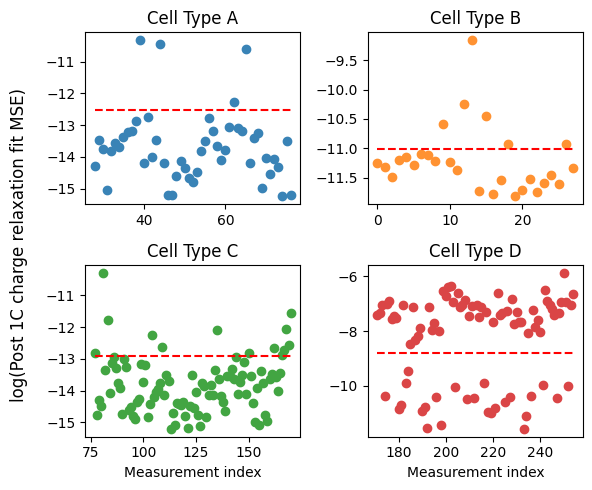

In [3]:
fig, axes = plt.subplots(2,2, figsize=(6,5))
axes = axes.ravel()

colors = {
    0: (50/225, 116/225, 161/225),
    1: (225/225, 129/225, 44/225),
    2: (58/225, 146/225, 58/225),
    3: (192/225, 61/225, 62/225),
}

THRESHOLDS = {  # safety = 'Post 1C charge relaxation fit MSE'
    0: 3.6e-6,
    1: 0.0000165,
    2: 2.5e-06,
    3: 1.5e-4,
}

# THRESHOLDS = {  # safety = 'Post C/2 charge relaxation fit MSE'
#     0: 3.6e-6,
#     1: 0.0000275,
#     2: 5.7e-06,
#     3: 0.9e-4,
# }

cell_names = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
}

for cell_type in range(4):
    a = targets_raw[targets_raw['cell_type'] == cell_type]
    axes[cell_type].scatter(x=a.index, y=np.log(a[safety]), color=colors[cell_type],
               label=INT_TO_TYPE_MAP[cell_type])
    axes[cell_type].hlines(np.log(THRESHOLDS[cell_type]), xmin=a.index.min(), xmax=a.index.max(), linestyles='dashed', colors='red') # , label='q25')
    axes[cell_type].set_title(f"Cell Type {cell_names[cell_type]}")

fig.supylabel(f"log({safety})")
axes[2].set_xlabel('Measurement index')
axes[3].set_xlabel('Measurement index')
fig.tight_layout()

## 

## Comparing Models

In [4]:
def squash_cv_results(df, models=["PLSR", "XGB", "NN", "BiLSTM", "CNNBiLSTM"], n_folds=5):
    for model_type in models:
        df[model_type] = np.nan
        for i in range(n_folds):
            df[model_type] = df[model_type].fillna(df[f"{i}_{model_type}"])
            df = df.drop(columns=[f"{i}_{model_type}"])
    return df

In [5]:
def load_model_comparison_results(target='soc'):
    results_all = {
        'r2': [],
        'mae': [],
        'cell_type': [],
        'model': [],
        'feature': [],
    }

    for cell_type in ['A', 'B', 'C', 'D']:
        for feature in ['Static HPPC', 'Static PsRP 1', 'Dynamic PsRP 1 C_2']:
            df = torch.load(f"../../results/experiment_comparing_models/{cell_type}_{target}_{feature}.pth")
            df = squash_cv_results(df)
            for model in ["PLSR", "XGB", "NN", "BiLSTM", "CNNBiLSTM"]:
                results_all['r2'].append(r2_score(df[target], df[model]))
                results_all['mae'].append(mean_absolute_error(df[target], df[model]))
                results_all['model'].append(model)
                results_all['feature'].append(feature)
                results_all['cell_type'].append(cell_type)
    return pd.DataFrame(results_all)


def plot_model_comparison(save_fn='../../figures/[supplemental]_Comparing_Models.png'):
    fig, axes = plt.subplots(2,2, figsize=(12,8))
    axes = axes.ravel()
    
    results_all = load_model_comparison_results('soc')
    sns.boxplot(results_all, x='feature', y='r2', hue='model', ax=axes[0])
    axes[0].set_xlabel("Input feature")
    axes[0].set_ylabel(r"$R^2$", size='xx-large')
    axes[0].legend(title='Model')
    sns.boxplot(results_all, x='feature', y='mae', hue='model', ax=axes[2])
    axes[2].set_xlabel("Input feature")
    axes[2].set_ylabel(r"MAE", size='xx-large')
    axes[2].legend(title='Model')
    axes[0].set_title("Predicting\nSOC", size='xx-large')

    results_all = load_model_comparison_results("1C discharge capacity")
    sns.boxplot(results_all, x='feature', y='r2', hue='model', ax=axes[1])
    axes[1].set_xlabel("Input feature")
    axes[1].legend(title='Model')
    axes[1].set_ylabel('')
    sns.boxplot(results_all, x='feature', y='mae', hue='model', ax=axes[3])
    axes[3].set_xlabel("Input feature")
    axes[3].legend(title='Model')
    axes[3].set_ylabel('')
    axes[1].set_title("Predicting\n1C discharge capacity", size='xx-large')
    
    fig.savefig(save_fn)

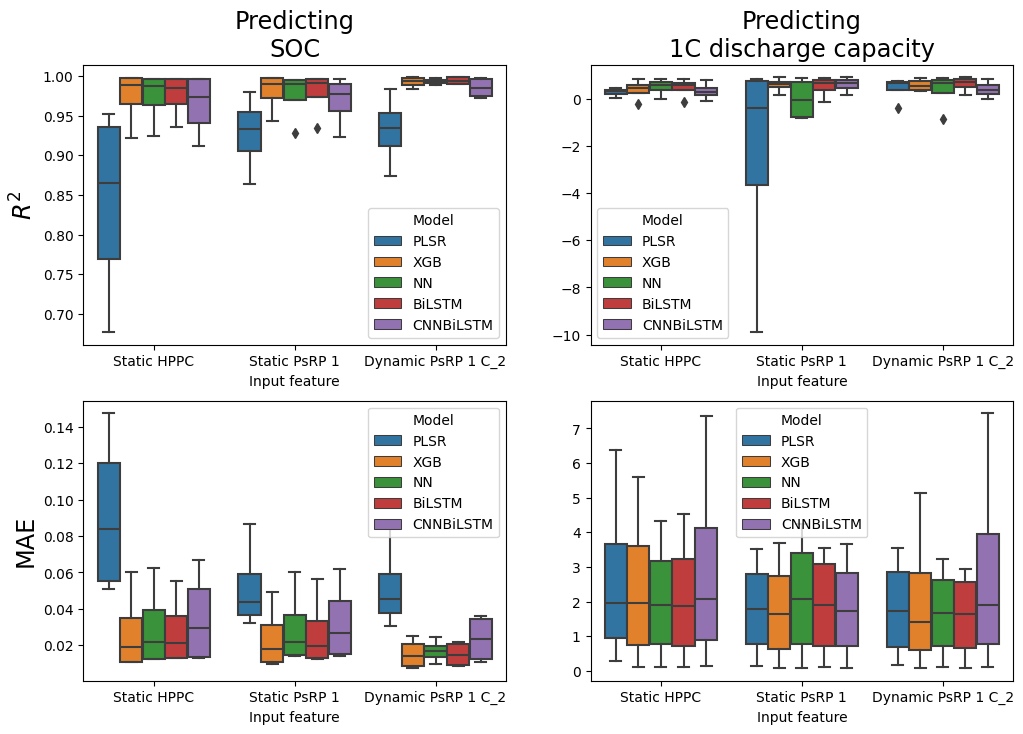

In [36]:
plot_model_comparison()  # ~10s

## Summary of all results

In [6]:
def plot_heatmap(pulses, targets, results_dict, metric='r2', display=True, n_runs=50, ax=None):
    r2_heatmap = np.zeros((len(pulses), len(targets)))
    mae_heatmap = np.zeros((len(pulses), len(targets)))

    for i, pulse in enumerate(pulses):
        for j, target in enumerate(targets):
            df = results_dict[f"{target}, {pulse}"]

            r2s, maes, rmses = [], [], []
            for run in range(n_runs):
                test_subset = df[df[run].notna()]
                r2 = r2_score(test_subset[target], test_subset[run])
                mae = mean_absolute_error(test_subset[target], test_subset[run])
                r2s.append(r2)
                maes.append(mae)

            r2_heatmap[i][j] = np.mean(r2s)
            mae_heatmap[i][j] = np.mean(maes)

    if metric == 'r2':
        heatmap = r2_heatmap
        label= r'Average R$^2$'
    else:
        heatmap = mae_heatmap
        label = r'Average $MAE$'
        
    if display:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,6))

        sns.heatmap(heatmap,
            cmap='viridis',
            cbar_kws={'label': label},
            xticklabels=[TARGETS_TO_NAMES[t] for t in targets],
            annot=True,
            yticklabels=pulses,
            ax=ax,
        )
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            horizontalalignment='right'
        );
    
    return heatmap

In [7]:
A = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_A_only.pth")
B = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_B_only.pth")
C = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_C_only.pth")
D = torch.load("../../results/RESULTS_xgboost_cells_D/bootstrap_results_D_only_with_P-I.pth")

TARGETS_TO_NAMES = {
    "1C discharge capacity": "1C discharge\ncapacity",
    "C/10 discharge capacity": "C/10",
    "C/5 discharge capacity": "C/5",
    "C/3 discharge capacity": "C/3 discharge\ncapacity",
    "C/2 discharge capacity": "C/2",
    "P/3 discharge capacity": "P/3",
    "Charge depleting cycle charge throughput": "Charge depleting\ncycle charge\nthroughput",
    "Charge sustaining cycle charge efficiency": "Charge sustaining\ncycle charge\nefficiency",
    "Post 1C charge relaxation fit MSE": "Post 1C charge\nrelaxation fit MSE",
    "soc": "SOC",
}

pulses = [
        'Static HPPC',
        'Static Rapid',
        'Static PsRP 1',
        'Static PsRP 2 Chg',
        'Static PsRP 2 Dis',
        'Dynamic PsRP 1 C/2',
        'Dynamic PsRP 1 1C',
        'Dynamic PsRP 2 C/2',
        'Dynamic PsRP 2 1C',
]

targets = [
    "1C discharge capacity",
    "C/3 discharge capacity",
    "Charge depleting cycle charge throughput",
    "Charge sustaining cycle charge efficiency",
]

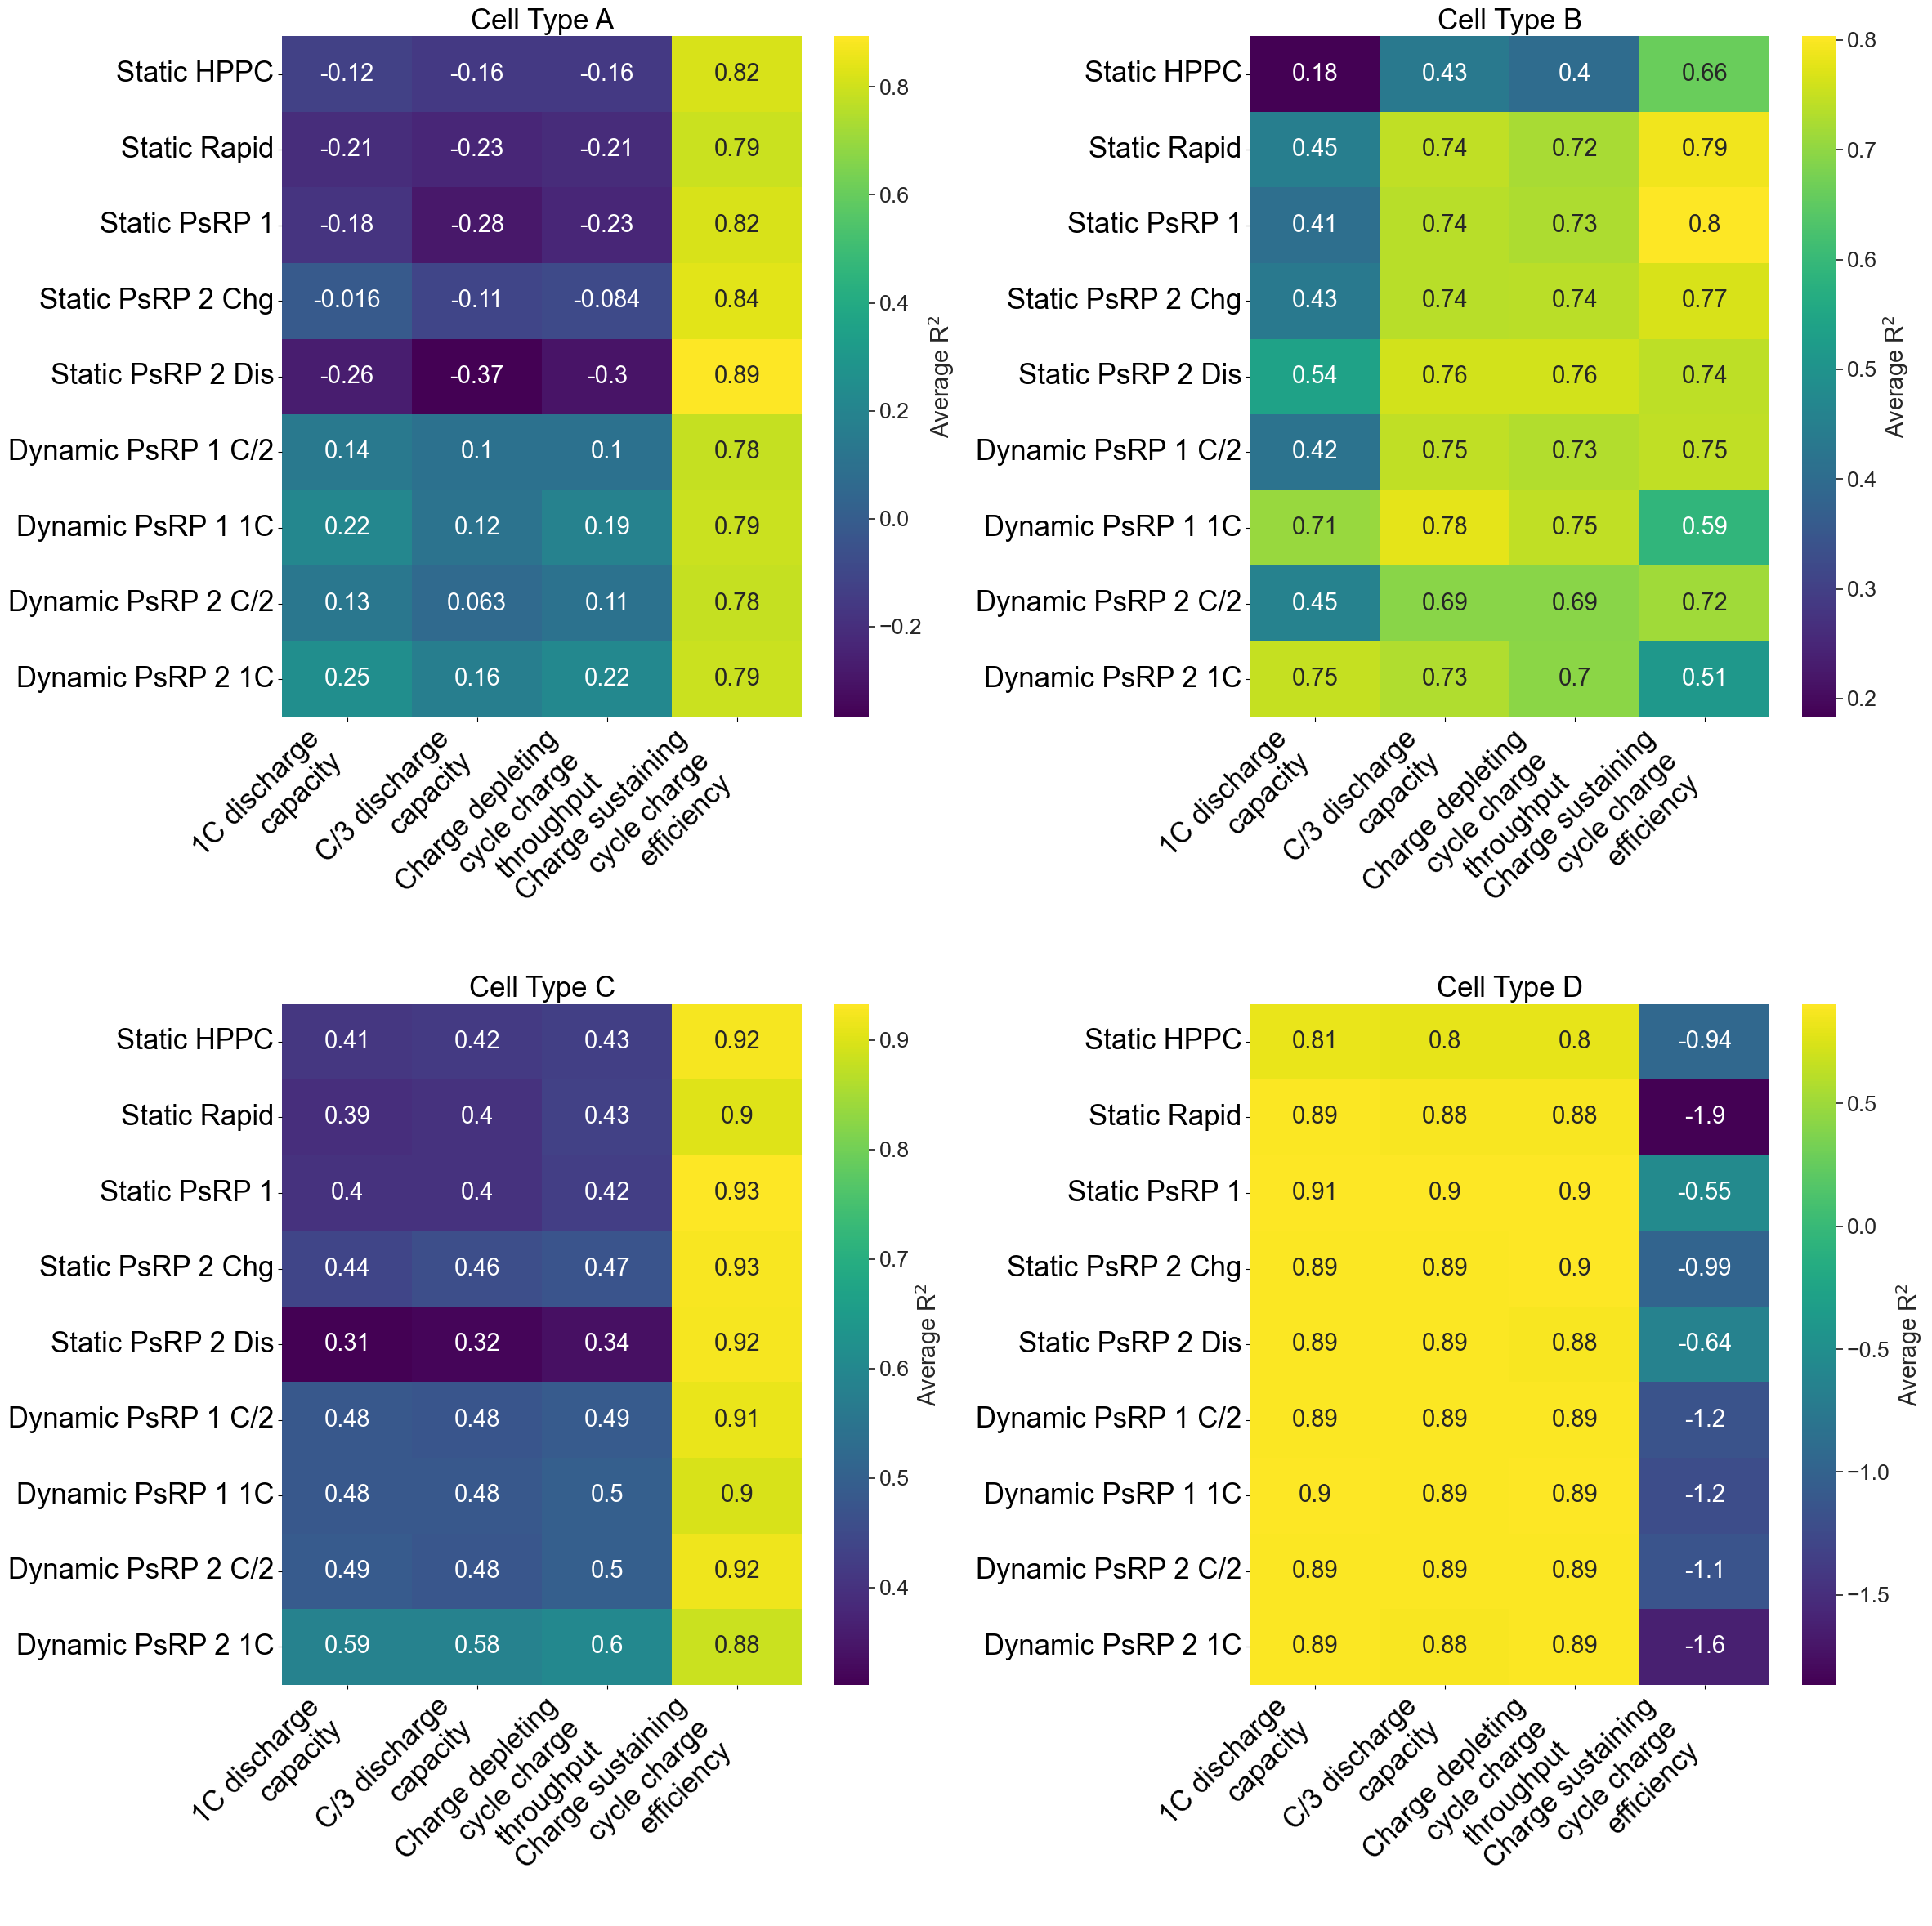

In [8]:
fig, ax = plt.subplots(2,2, figsize=(24,24))
ax = ax.ravel()
sns.set(font_scale=1.75)
plot_heatmap(pulses, targets, A, metric='r2', ax=ax[0]);
plot_heatmap(pulses, targets, B, metric='r2', ax=ax[1]);
plot_heatmap(pulses, targets, C, metric='r2', ax=ax[2]);
plot_heatmap(pulses, targets, D, metric='r2', ax=ax[3]);
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=25)
ax[0].set_title("Cell Type A", fontsize=25)
ax[1].set_title("Cell Type B", fontsize=25)
ax[2].set_title("Cell Type C", fontsize=25)
ax[3].set_title("Cell Type D", fontsize=25)
fig.tight_layout()
plt.show()
sns.set(font_scale=1)
fig.savefig("../../figures/[supplemental]_AllPulses_AllTargets.png")

## Current as an input feature

In [38]:
A_no_current = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_no_current_A_only.pth")
B_no_current = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_no_current_B_only.pth")
C_no_current = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_no_current_C_only.pth")
A_soc = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_soc_A_only.pth")
B_soc = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_soc_B_only.pth")
C_soc = torch.load("../../results/RESULTS_xgboost_cells_A-C/bootstrap_results_soc_C_only.pth")

pulses = [
    "Static Rapid",
    "Static HPPC",
    "Static PsRP 1",
    "Dynamic PsRP 1 C/2"
]

targets = [
    "1C discharge capacity",
    "C/3 discharge capacity",
    "Charge depleting cycle charge throughput",
    "Charge sustaining cycle charge efficiency",
    "soc",
]

def compare_results_with_and_without_current(current, no_current, current_soc, pulse, targets, n_splits=50):
    
    r2s_current, maes_current = [], []
    r2s_no_current, maes_no_current = [], []

    for target in targets:
        if target == 'soc':
            df_current = current_soc[f"{target}, {pulse}"]
        else:
            df_current = current[f"{target}, {pulse}"]
        
        df_no_current = no_current[f"{target}, {pulse}"]
        
        average_pred = df_current[list(range(n_splits))].mean(axis=1)
        r2s_current.append(r2_score(df_current[target], average_pred))
        maes_current.append(mean_absolute_error(df_current[target], average_pred))
        
        average_pred = df_no_current[list(range(n_splits))].mean(axis=1)
        r2s_no_current.append(r2_score(df_no_current[target], average_pred))
        maes_no_current.append(mean_absolute_error(df_no_current[target], average_pred))

    display(pd.DataFrame({
        'Target': targets,
        'MAE\n (input = [V, I, T, t])': maes_current,
        'MAE\n(input = [V, T, t])': maes_no_current,
    }))

In [39]:
compare_results_with_and_without_current(A, A_no_current, A_soc, 'Static HPPC', targets)

,Target,"MAE\n (input = [V, I, T, t])","MAE\n(input = [V, T, t])"
0,1C discharge capacity,2.449524,2.583017
1,C/3 discharge capacity,2.581863,2.726261
2,Charge depleting cycle charge throughput,3.439531,3.510826
3,Charge sustaining cycle charge efficiency,0.001266,0.002181
4,soc,0.011945,0.011189


In [40]:
compare_results_with_and_without_current(C, C_no_current, C_soc, 'Static PsRP 1', targets)

,Target,"MAE\n (input = [V, I, T, t])","MAE\n(input = [V, T, t])"
0,1C discharge capacity,0.648127,0.667534
1,C/3 discharge capacity,0.635651,0.666064
2,Charge depleting cycle charge throughput,0.847537,0.902732
3,Charge sustaining cycle charge efficiency,0.000647,0.002573
4,soc,0.008121,0.007870


## Systematic errors, all targets and cell types

In [101]:
def get_true_pred_metadata(result_dict, target, pulses):
    true, pred = [], []
    temp, rate, soc = [], [], []
    iteration = []
    mae = []
    
    for pulse in pulses:
        df = result_dict[f"{target}, {pulse}"]
        for i in range(50):
            subset = df[df[i].notna()]
            true += subset[target].to_list()
            pred += subset[i].to_list()
            temp += subset['temperature_ambient'].to_list()
            if 'rate' in subset:
                rate += subset['rate'].to_list()
            else:
                rate += [np.nan] * len(subset)
            if 'soc' in subset:
                soc += subset['soc'].to_list()
            else:
                soc += [np.nan] * len(subset)
            iteration += [i] * len(subset)
            mae += [mean_absolute_error(subset[target], subset[i])] * len(subset)
    
    residual = np.array(true) - np.array(pred)
    return pd.DataFrame({"True": true, f"Predicted": pred,
                         "Residual": residual,
                         "MAE": mae,
                         'Temperature': temp, 'C-rate': rate,
                         'SOC': soc, "Iteration": iteration})

def plot_errors(axes, df, target, cell_id):
    colors = {
        "A": (50/225, 116/225, 161/225),
        "B": (225/225, 129/225, 44/225),
        "C": (58/225, 146/225, 58/225),
        "D": (192/225, 61/225, 62/225),
    }
    
    df_metadata = get_true_pred_metadata(df, target, ['Static HPPC'])
    
    # Effect of temperature
    sns.histplot(df_metadata, x='Temperature', y='Residual', ax=axes[0], color=colors[cell_id])
    axes[0].hlines(xmin=axes[0].get_xlim()[0], xmax=axes[0].get_xlim()[1], y=0, linestyle='dashed', color='grey')
    axes[0].set_ylabel("Residual (Ah)")
    
    # Effect of rate
    # v1
    df_metadata['abs(Residual)'] = abs(df_metadata['Residual'])
    m = df_metadata.groupby('C-rate').mean().loc[['C/10', 'C/2', '1C', '2C']]
    yerr = df_metadata.groupby('C-rate').std().loc[['C/10', 'C/2', '1C', '2C']]
    axes[1].errorbar(m.index, m['abs(Residual)'], fmt='o', yerr=yerr['abs(Residual)'], capsize=5, color=colors[cell_id])   
    axes[1].set_xlabel("C-rate")
    axes[1].set_ylabel("MAE (Ah)")
    axes[2].errorbar(m.index, m['abs(Residual)'], fmt='o', color=colors[cell_id])
    
    # Effect of SOC
    sns.histplot(df_metadata, x='SOC', y='Residual', ax=axes[3], color=colors[cell_id])
    axes[3].hlines(xmin=0, xmax=1, y=0, linestyle='dashed', color='grey')
    axes[3].set_ylabel("Residual (Ah)")

def plot_errors_no_soc(axes, df, target, cell_id):
    colors = {
        "A": (50/225, 116/225, 161/225),
        "B": (225/225, 129/225, 44/225),
        "C": (58/225, 146/225, 58/225),
        "D": (192/225, 61/225, 62/225),
    }
    
    df_metadata = get_true_pred_metadata(df, target, ['Static HPPC'])
    
    # Effect of temperature
    sns.histplot(df_metadata, x='Temperature', y='Residual', ax=axes[0], color=colors[cell_id])
    axes[0].hlines(xmin=axes[0].get_xlim()[0], xmax=axes[0].get_xlim()[1], y=0, linestyle='dashed', color='grey')
    axes[0].set_ylabel("Residual (Ah)")
    
    # Effect of rate
    df_metadata['abs(Residual)'] = abs(df_metadata['Residual'])
    m = df_metadata.groupby('C-rate').mean().loc[['C/10', 'C/2', '1C', '2C']]
    yerr = df_metadata.groupby('C-rate').std().loc[['C/10', 'C/2', '1C', '2C']]
    axes[1].errorbar(m.index, m['abs(Residual)'], fmt='o', yerr=yerr['abs(Residual)'], capsize=5, color=colors[cell_id])   
    axes[1].set_xlabel("C-rate")
    axes[1].set_ylabel("MAE (Ah)")
    axes[2].errorbar(m.index, m['abs(Residual)'], fmt='o', color=colors[cell_id])

In [111]:
def plot_systematic_errors(target, save_fn="../../figures/systematic_errors.png"):
    sns.set(font_scale=1.5)
    sns.set_style("white")
    fig, axes = plt.subplots(4, 4, figsize=(16,16))
    plot_errors(axes[0], A, target, 'A')
    plot_errors(axes[1], B, target, 'B')
    plot_errors(axes[2], C, target, 'C')
    plot_errors(axes[3], D, target, 'D')
    axes[0,0].set_title("Effect of\nTemperature")
    axes[0,1].set_title("Effect of\nC-rate")
    axes[0,2].set_title("Effect of\nC-rate (Zoom view)")
    axes[0,3].set_title("Effect of\nSOC")
    for ax in axes.ravel():
        ax.set_xlabel("")
    axes[3,0].set_xlabel("Temperature (C)")
    axes[3,1].set_xlabel("C-rate")
    axes[3,2].set_xlabel("C-rate")
    axes[3,3].set_xlabel("SOC")
    axes[0,0].set_ylabel("Cell Type A\n\nResidual (Ah)")
    axes[1,0].set_ylabel("Cell Type B\n\nResidual (Ah)")
    axes[2,0].set_ylabel("Cell Type C\n\nResidual (Ah)")
    axes[3,0].set_ylabel("Cell Type D\n\nResidual (Ah)")
    sns.set(font_scale=1)
    fig.tight_layout()
    fig.savefig(save_fn)

def plot_systematic_errors_soc(save_fn="../../figures/systematic_errors.png"):

    target = 'soc'
    
    sns.set(font_scale=1.5)
    sns.set_style("white")
    fig, axes = plt.subplots(4, 3, figsize=(16,16))
    plot_errors_no_soc(axes[0], A_soc, target, 'A')
    plot_errors_no_soc(axes[1], B_soc, target, 'B')
    plot_errors_no_soc(axes[2], C_soc, target, 'C')
    plot_errors_no_soc(axes[3], D, target, 'D')
    axes[0,0].set_title("Effect of\nTemperature")
    axes[0,1].set_title("Effect of\nC-rate")
    axes[0,2].set_title("Effect of\nC-rate (Zoom view)")
    for ax in axes.ravel():
        ax.set_xlabel("")
    axes[3,0].set_xlabel("Temperature (C)")
    axes[3,1].set_xlabel("C-rate")
    axes[3,2].set_xlabel("C-rate")
    axes[0,0].set_ylabel("Cell Type A\n\nResidual (Ah)")
    axes[1,0].set_ylabel("Cell Type B\n\nResidual (Ah)")
    axes[2,0].set_ylabel("Cell Type C\n\nResidual (Ah)")
    axes[3,0].set_ylabel("Cell Type D\n\nResidual (Ah)")
    sns.set(font_scale=1)
    fig.tight_layout()
    fig.savefig(save_fn)

In [99]:
# Add SOC measurements to D results dataframe

data_for_ml = pd.HDFStore("../../data/data_for_ml.h5")
all_data = data_for_ml.get("Static_HPPC")[['soc', 'cell_id', 'direction', 'rate', 'measurement_id']]
d = all_data[all_data['cell_id'].str.startswith("D")].reset_index(drop=True)

assert(len(d) == len(D['1C discharge capacity, Static HPPC']))
assert d['cell_id'].equals(D['1C discharge capacity, Static HPPC']['cell_id'])
assert d['measurement_id'].equals(D['1C discharge capacity, Static HPPC']['measurement_id'])
assert d['direction'].equals(D['1C discharge capacity, Static HPPC']['direction'])
assert d['rate'].equals(D['1C discharge capacity, Static HPPC']['rate'])
D['1C discharge capacity, Static HPPC']['soc'] = d['soc']

assert(len(d) == len(D['Charge sustaining cycle charge efficiency, Static HPPC']))
assert d['cell_id'].equals(D['Charge sustaining cycle charge efficiency, Static HPPC']['cell_id'])
assert d['measurement_id'].equals(D['Charge sustaining cycle charge efficiency, Static HPPC']['measurement_id'])
assert d['direction'].equals(D['Charge sustaining cycle charge efficiency, Static HPPC']['direction'])
assert d['rate'].equals(D['Charge sustaining cycle charge efficiency, Static HPPC']['rate'])
D['Charge sustaining cycle charge efficiency, Static HPPC']['soc'] = d['soc']


assert(len(d) == len(D['Charge depleting cycle charge throughput, Static HPPC']))
assert d['cell_id'].equals(D['Charge depleting cycle charge throughput, Static HPPC']['cell_id'])
assert d['measurement_id'].equals(D['Charge depleting cycle charge throughput, Static HPPC']['measurement_id'])
assert d['direction'].equals(D['Charge depleting cycle charge throughput, Static HPPC']['direction'])
assert d['rate'].equals(D['Charge depleting cycle charge throughput, Static HPPC']['rate'])
D['Charge depleting cycle charge throughput, Static HPPC']['soc'] = d['soc']

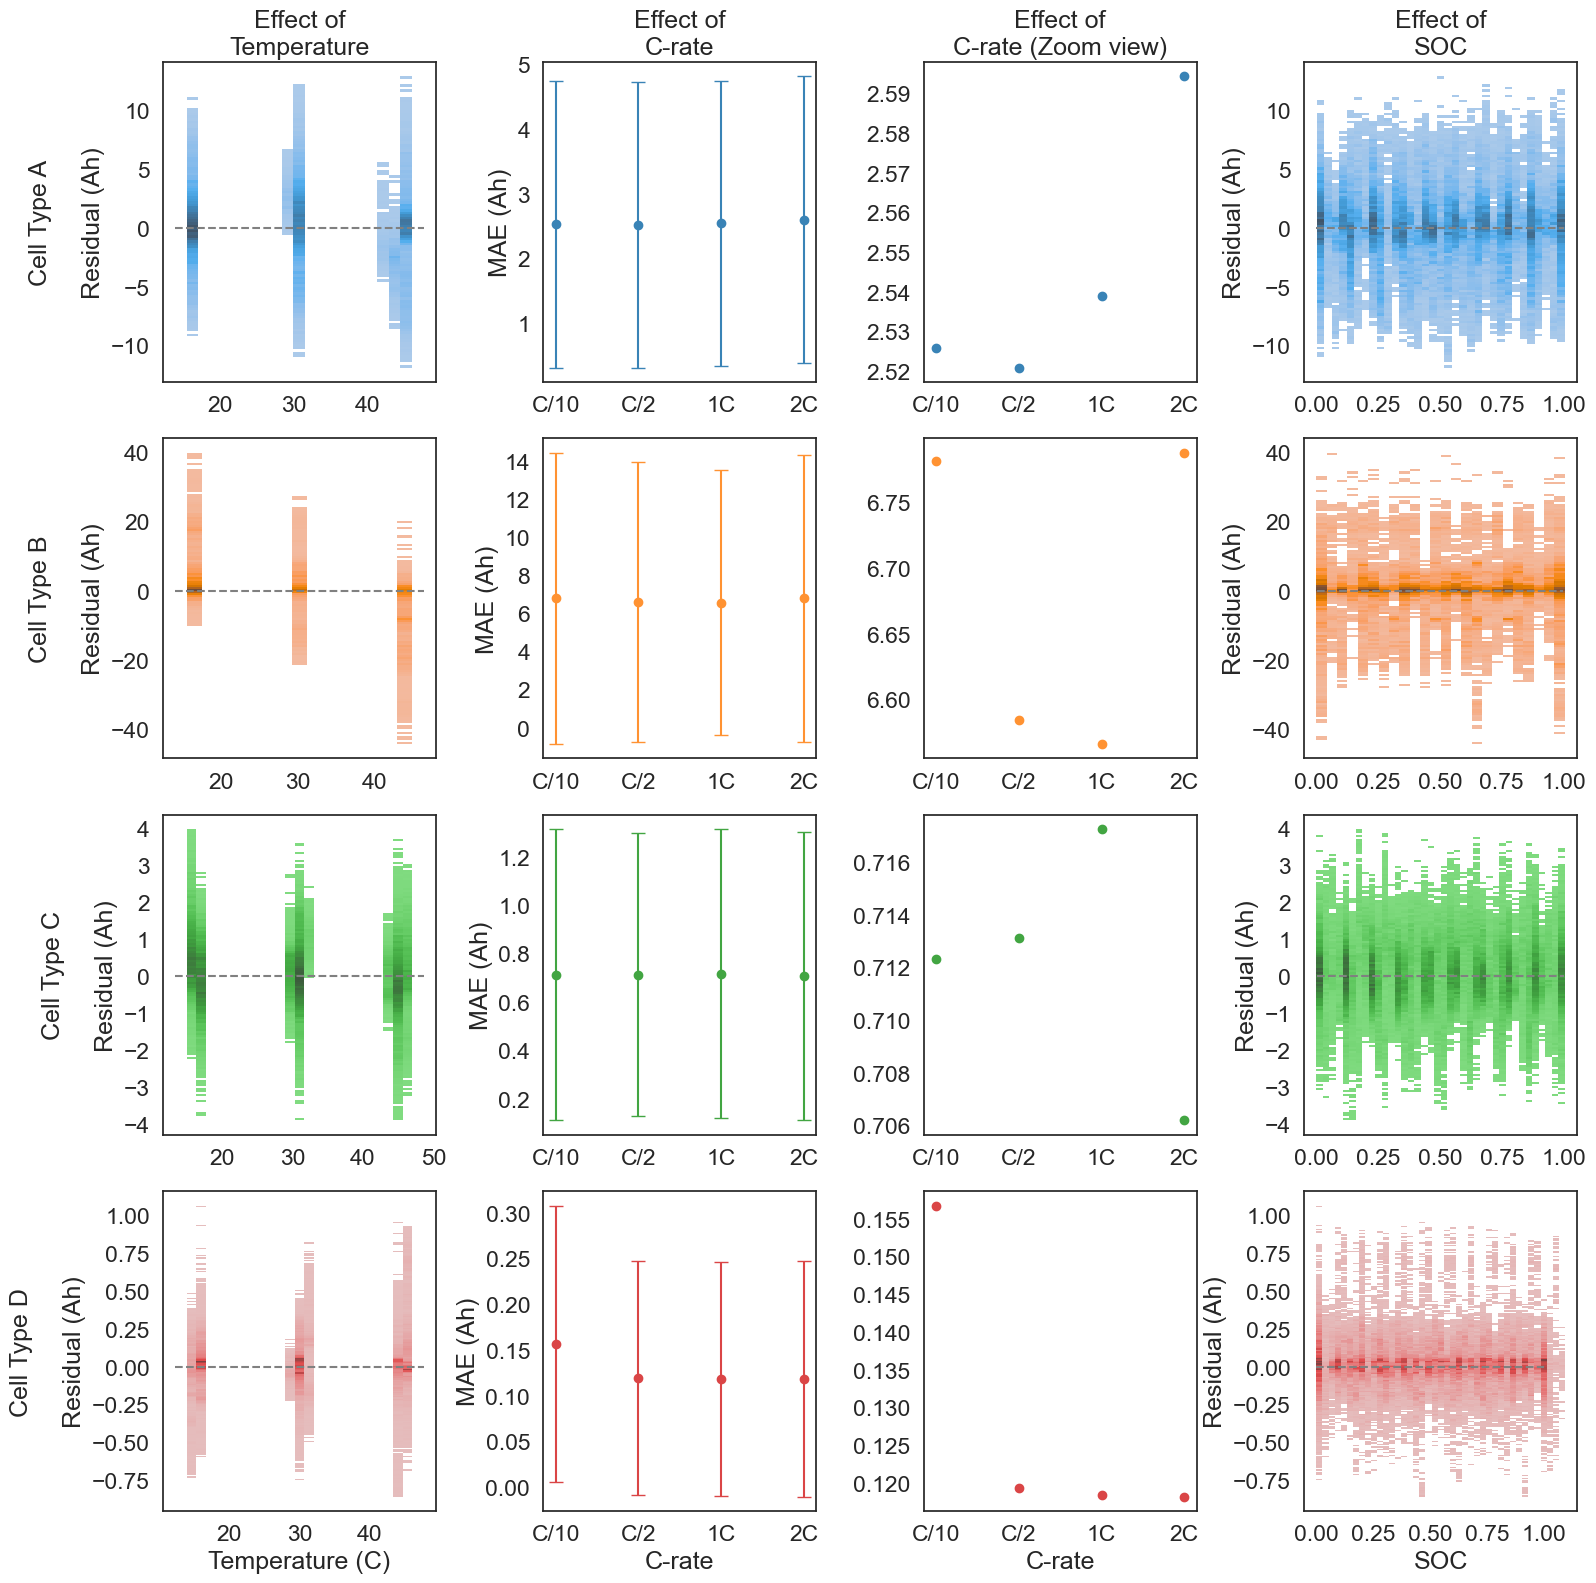

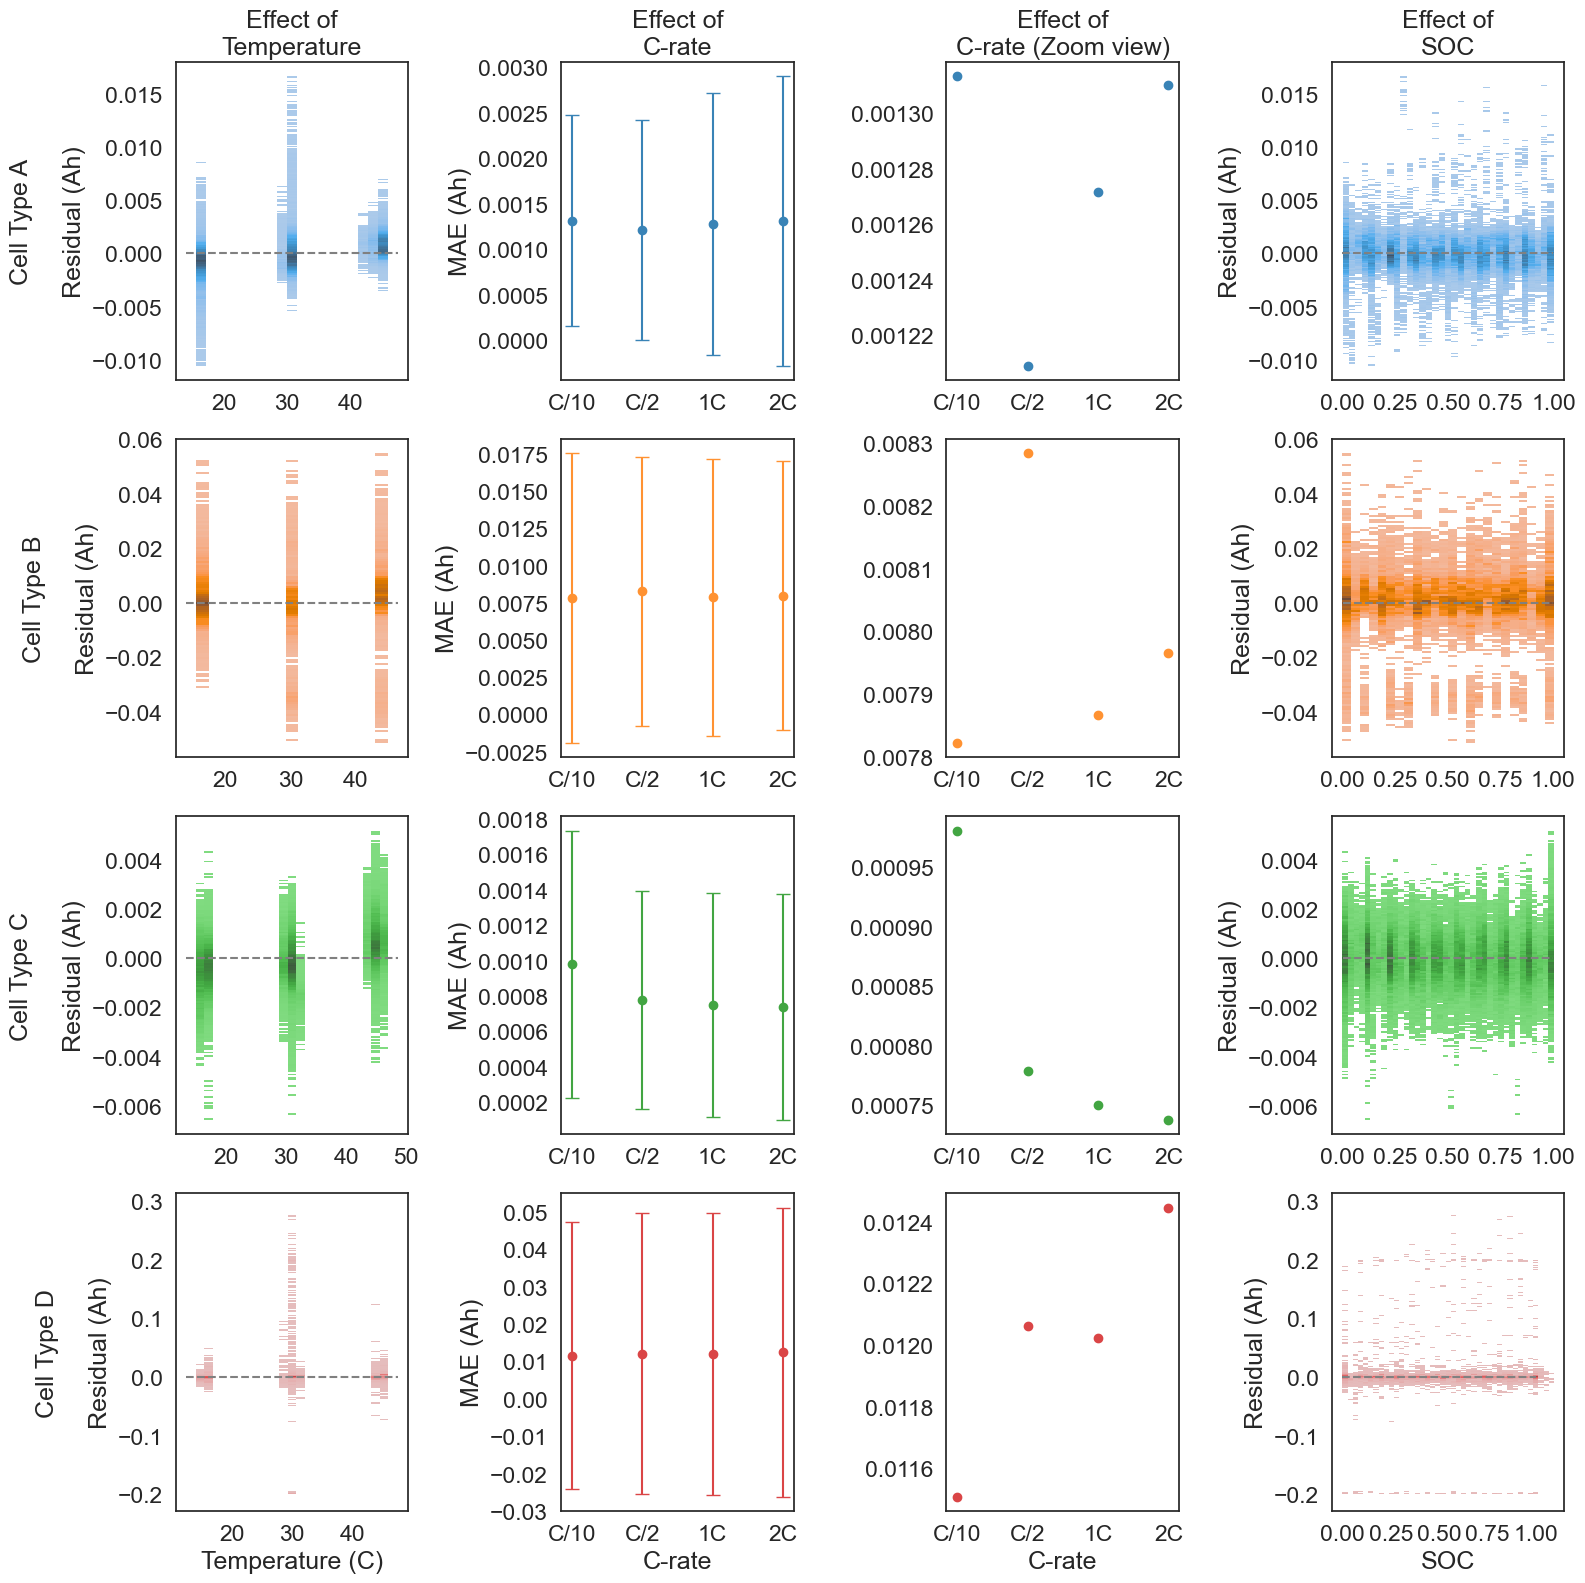

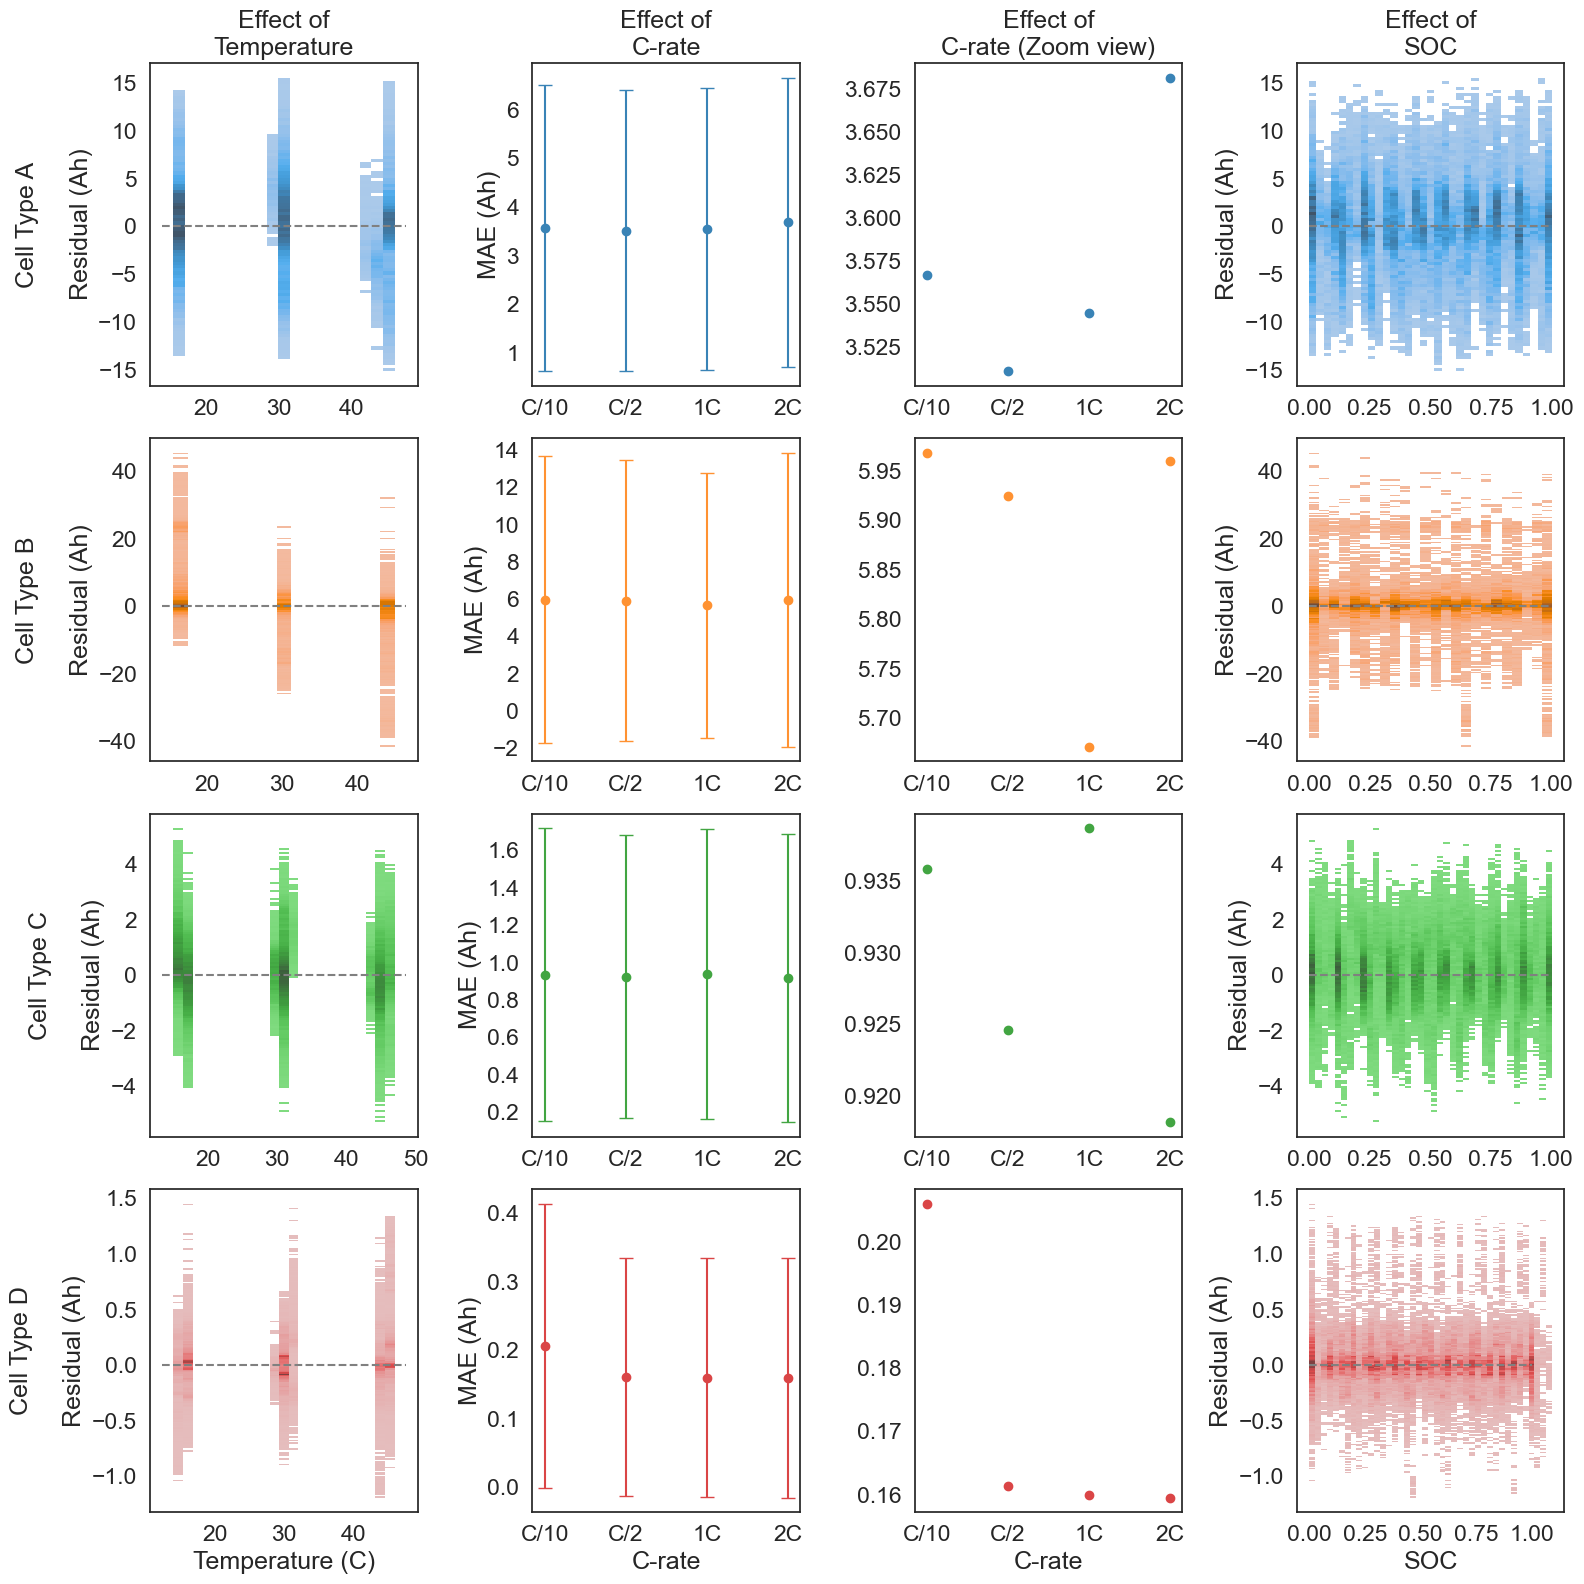

In [100]:
plot_systematic_errors('1C discharge capacity', '../../figures/[supplemental]_Systematic_Errors_1C_discharge_capacity.png')
plot_systematic_errors('Charge sustaining cycle charge efficiency', '../../figures/[supplemental]_Systematic_Errors_CE.png')
plot_systematic_errors('Charge depleting cycle charge throughput', '../../figures/[supplemental]_Systematic_Errors_Throughput.png')

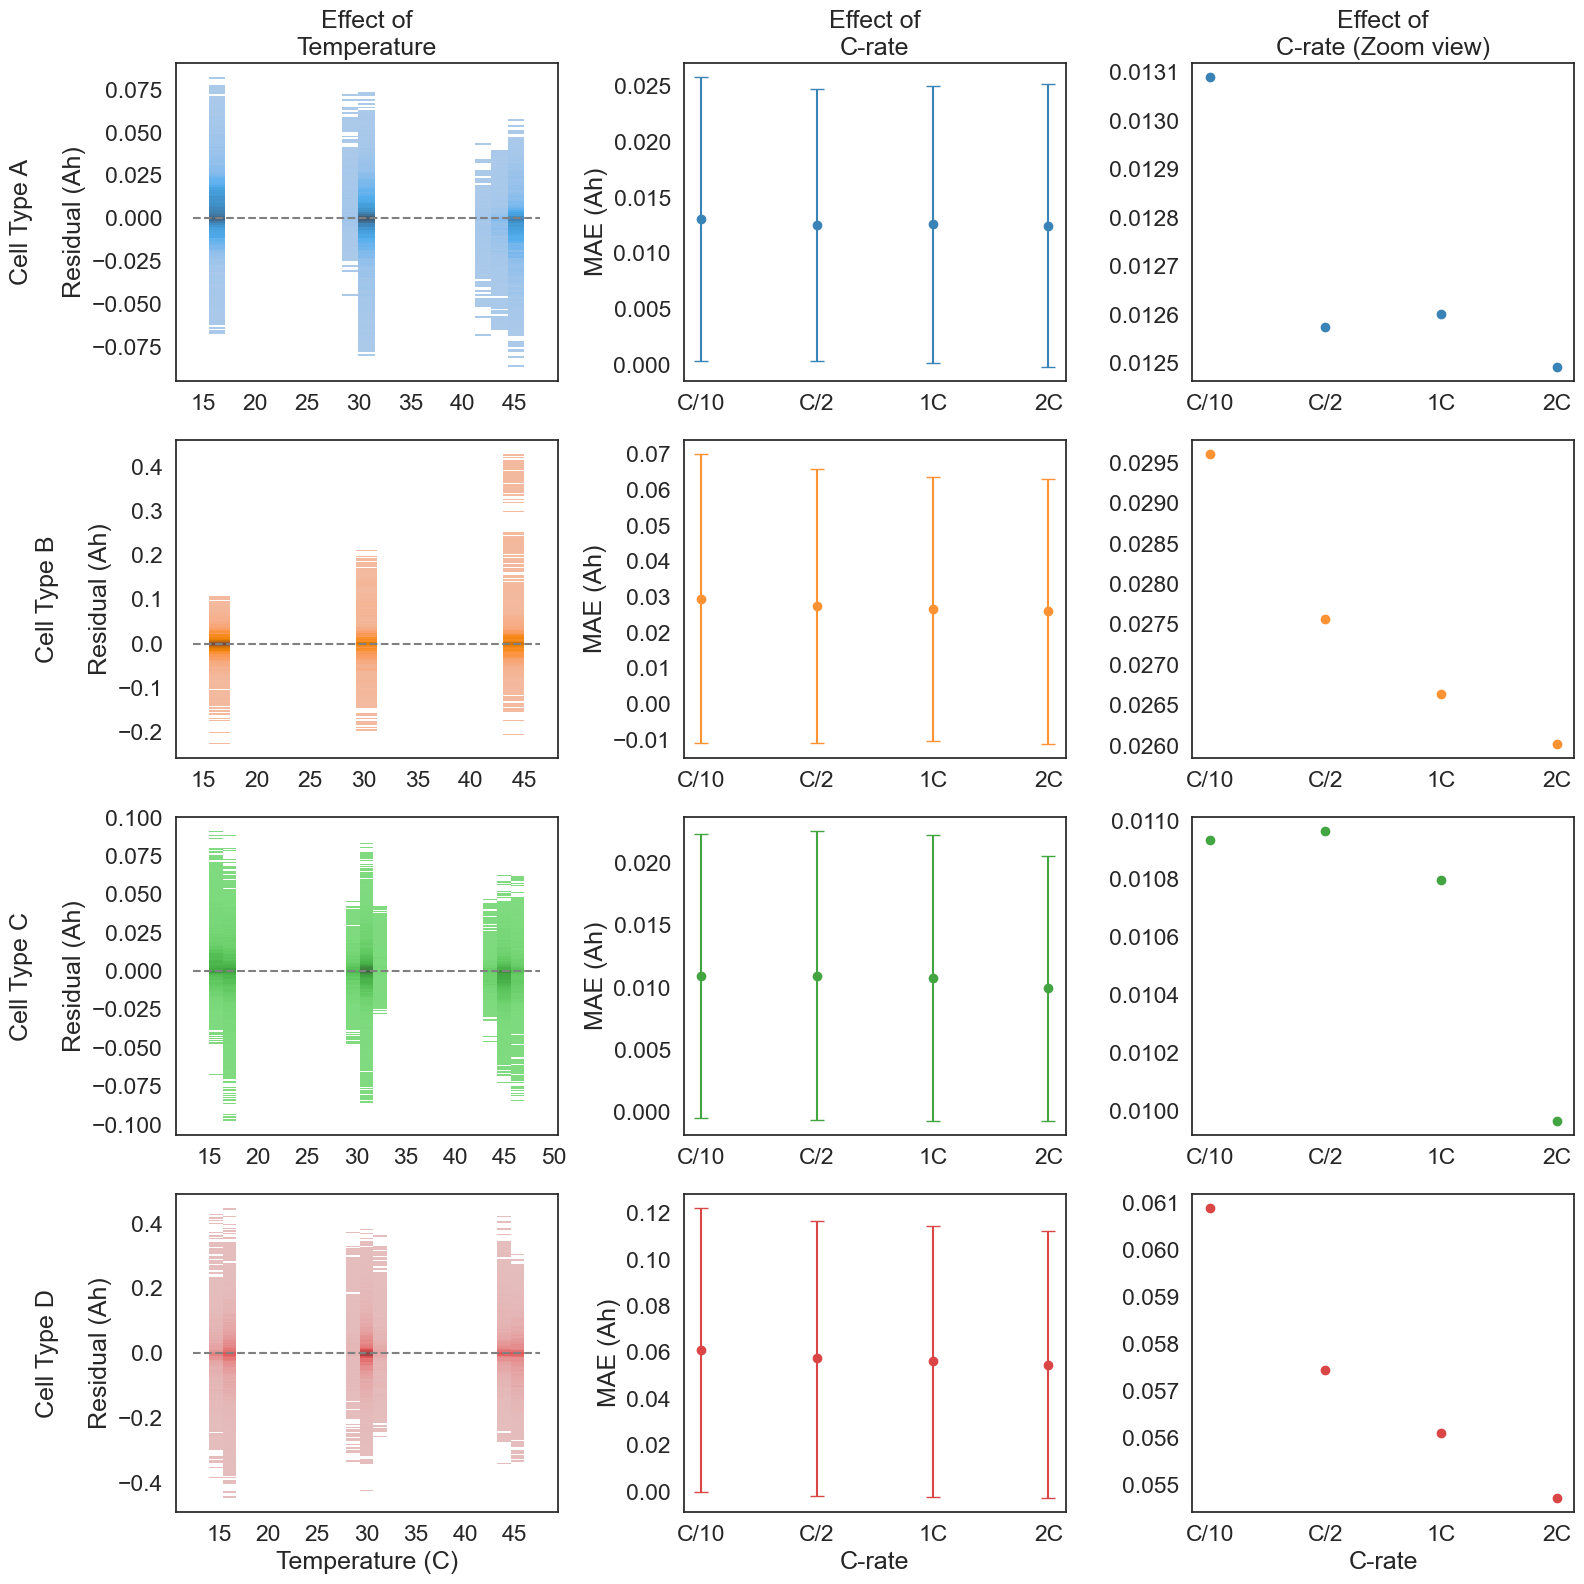

In [112]:
plot_systematic_errors_soc('../../figures/[supplemental]_Systematic_Errors_SOC.png')